In [4]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [5]:
df = pd.read_csv('Zemlya.csv', index_col=0)
df['x'].fillna(df['x'].mean(), inplace=True)

In [36]:
df['MA_window_3'] = df['x'].rolling(window=10).mean()
df

,x,MA_window_3,MA_window_6
1,-143,NaN,NaN
2,-114,NaN,NaN
3,4609,NaN,NaN
4,7309,NaN,NaN
5,3372,NaN,NaN
...,...,...,...
3044,-2335,2913.1,2539.668333
3045,-2665,2293.7,2552.211667
3046,1721,1765.7,2579.891667
3047,5358,1458.1,2604.603333


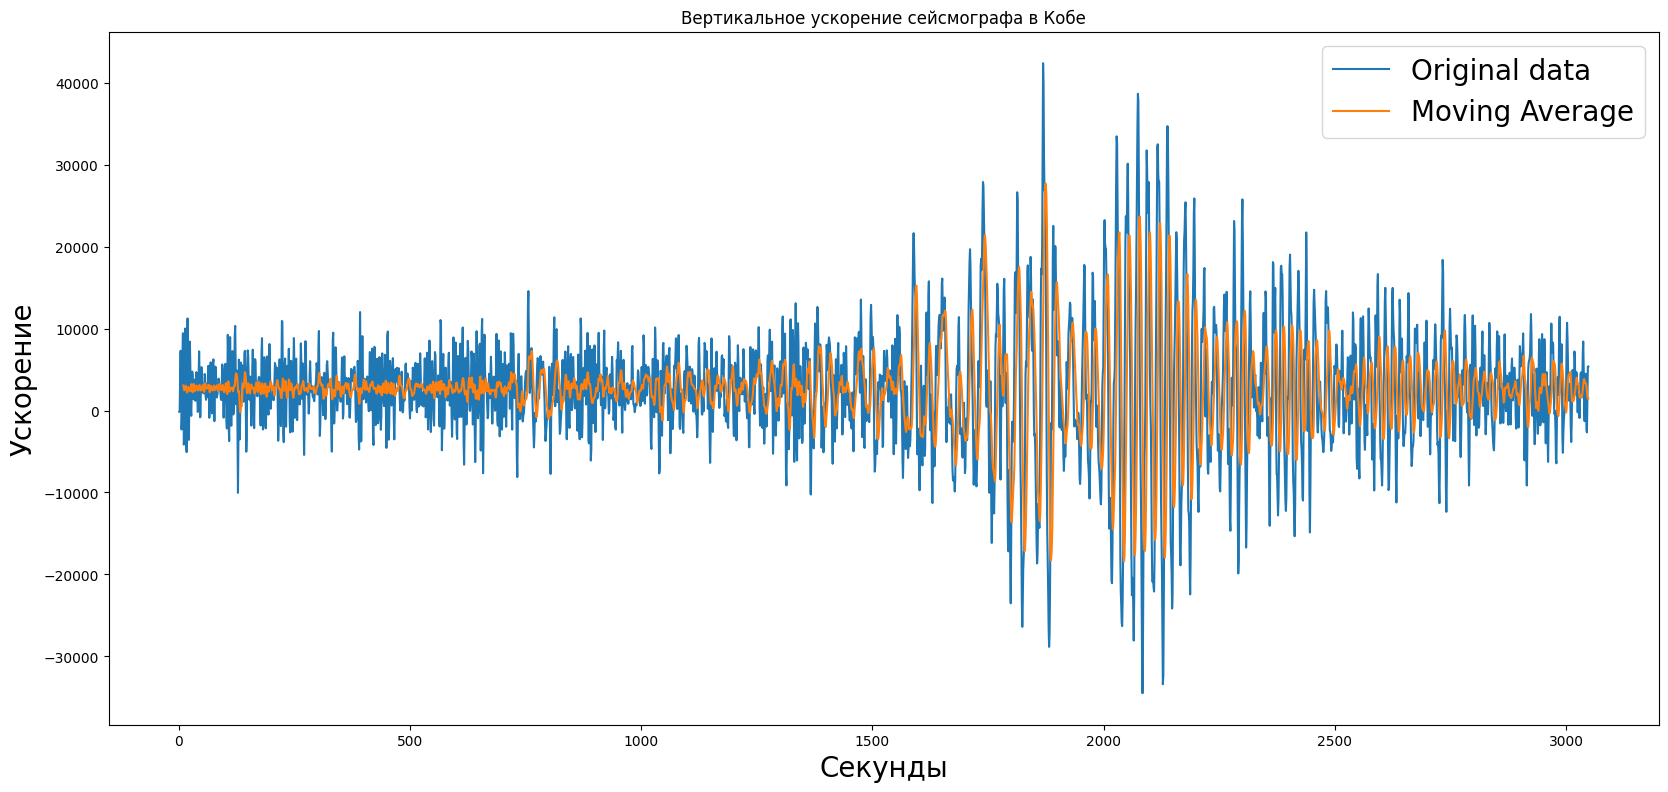

In [37]:
fig = plt.figure(figsize=(20, 9))
plt.plot(df['x'], label='Original data')
plt.plot(df['MA_window_3'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('Вертикальное ускорение сейсмографа в Кобе')
plt.ylabel('Ускорение', fontsize="20")
plt.xlabel('Секунды', fontsize="20")
plt.show()

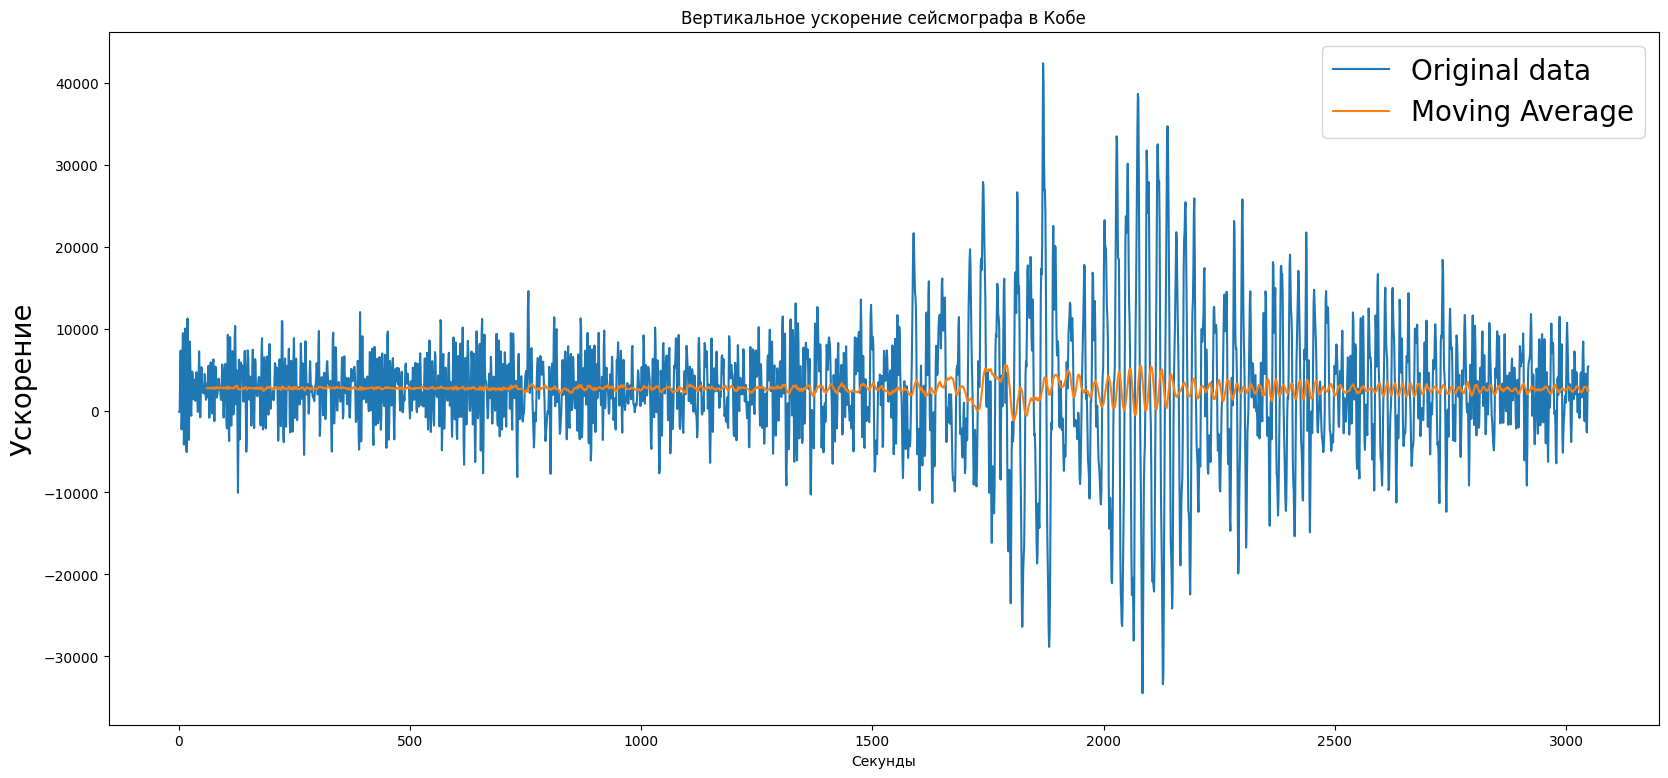

In [39]:
df['MA_window_6'] = df['x'].rolling(window=60).mean()
fig = plt.figure(figsize=(20, 9))
plt.plot(df['x'], label='Original data')
plt.plot(df['MA_window_6'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('Вертикальное ускорение сейсмографа в Кобе')
plt.ylabel('Ускорение', fontsize="20")
plt.xlabel('Секунды')
plt.show()

In [40]:
'''
Отрисовка скользящего среднего по медиане для ts с 95% доверительным интервалом для стандартного отклонения.
:parameter
  :param ts: датасет
  :param window: кол-во семплов в окне - для скользящих средних
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=100,
            figsize=(15,5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='Реальные значения', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window),
                 color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
    plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                     color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

<ipython-input-40-8025967e2416>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


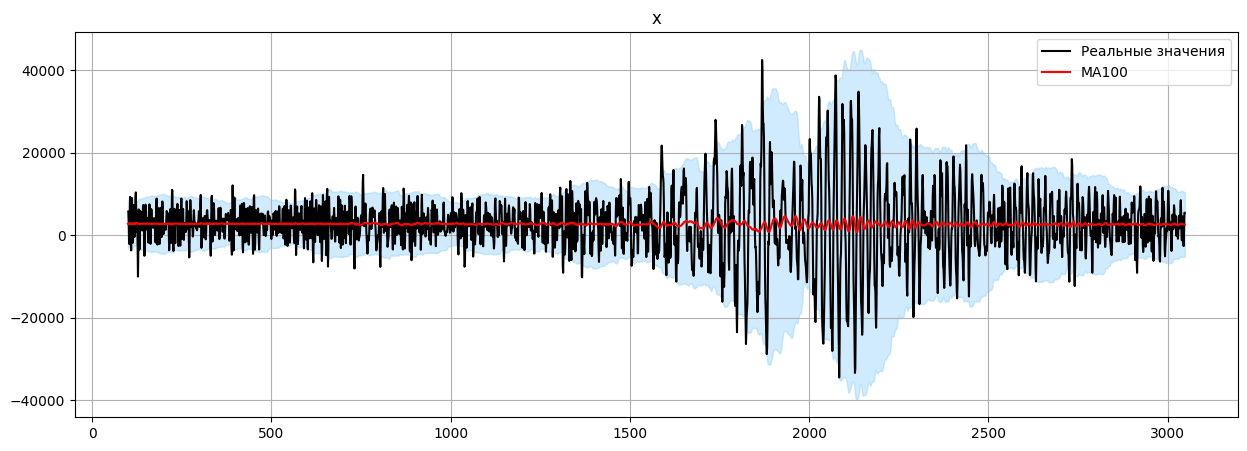

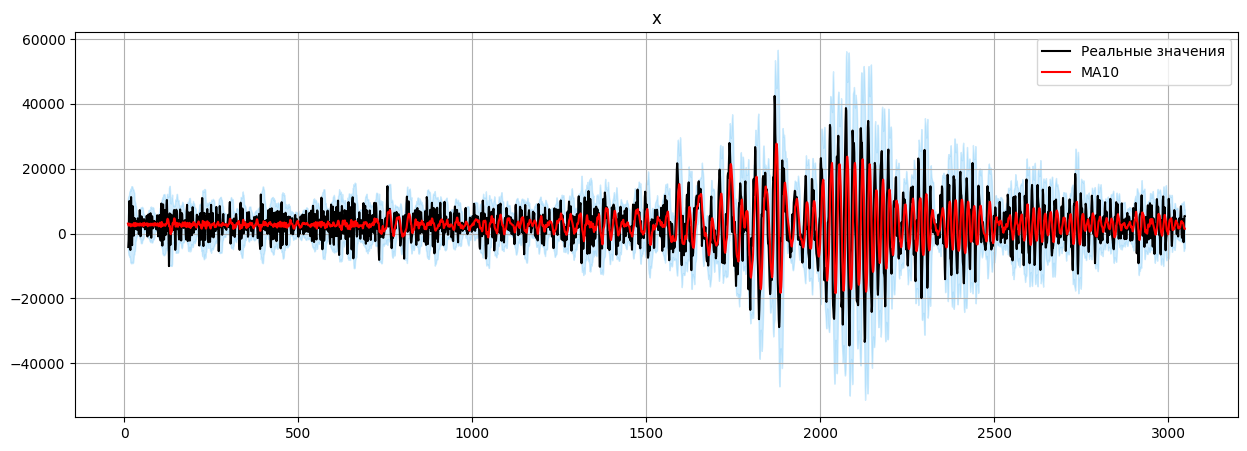

In [41]:
plot_ts(df["x"], window=100)
plot_ts(df["x"], window=10)

In [11]:
from statsmodels.tsa.arima.model import ARIMA

In [12]:
arma_model = ARIMA(df['x'], order=(5,0,3))
arma_model_fit = arma_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

In [42]:
print(arma_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                 3048
Model:                 ARIMA(5, 0, 3)   Log Likelihood              -24254.148
Date:                Mon, 06 Nov 2023   AIC                          48528.296
Time:                        04:28:56   BIC                          48588.519
Sample:                             0   HQIC                         48549.941
                               - 3048                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2645.6110    126.596     20.898      0.000    2397.488    2893.734
ar.L1          2.6206      0.038     68.459      0.000       2.546       2.696
ar.L2         -3.3136      0.091    -36.302      0.0

In [44]:
X = df['x'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

KeyboardInterrupt: ignored

In [45]:
print(len(train))
print(len(test))
print(len(arma_predictions))

2011
1037
264


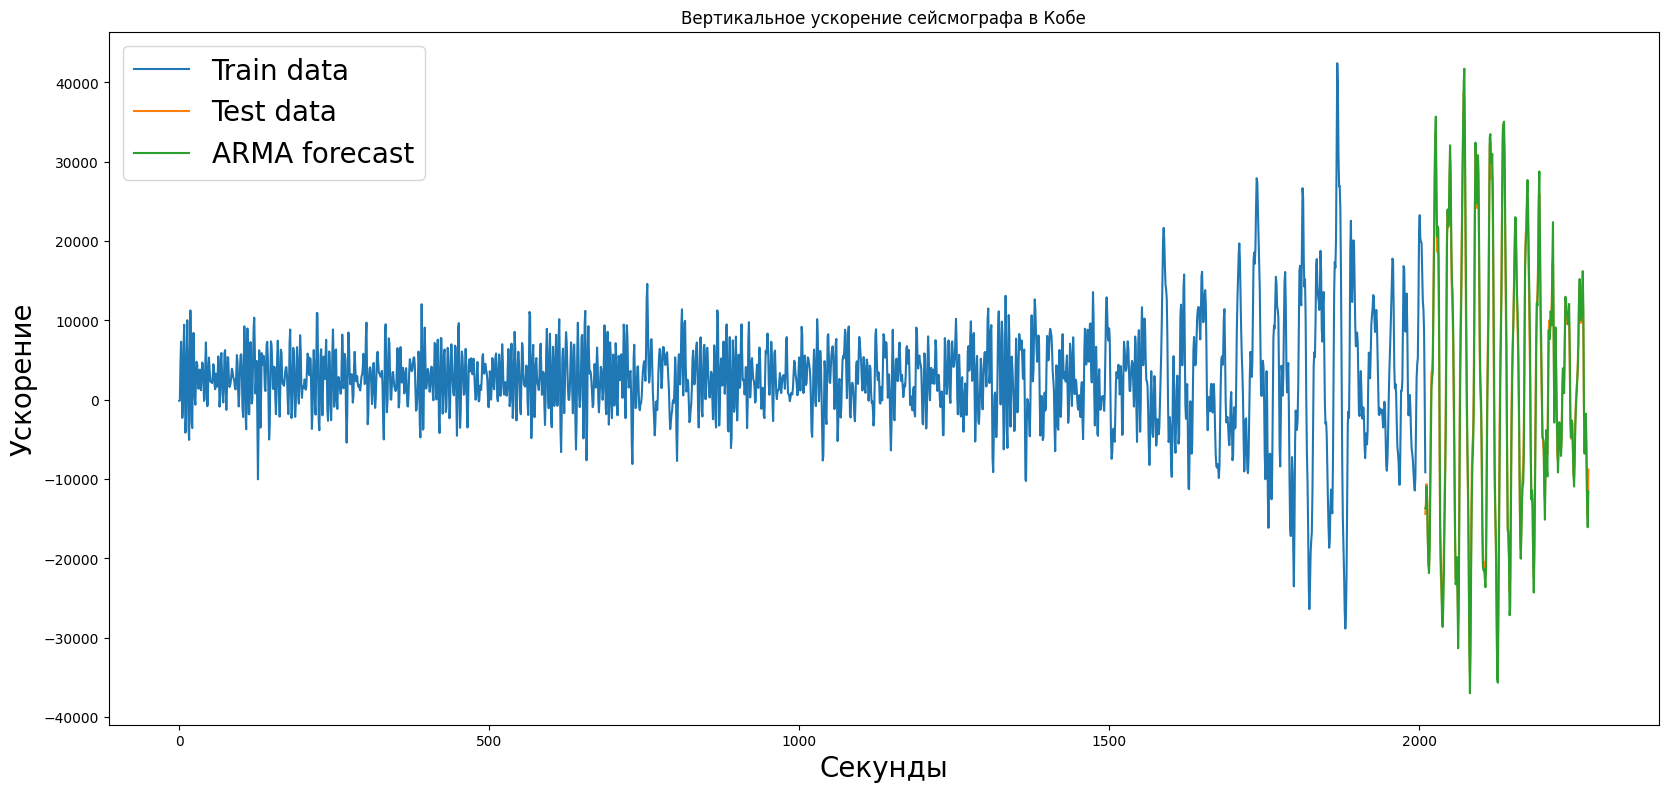

In [46]:
fig = plt.figure(figsize=(20, 9))
dur = len(arma_predictions)

plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_predictions, label='ARMA forecast')
plt.legend(fontsize="20")
plt.title('Вертикальное ускорение сейсмографа в Кобе')
plt.ylabel('Ускорение', fontsize="20")
plt.xlabel('Секунды', fontsize="20")
plt.show()

In [47]:
data = pd.read_csv('Zemlya.csv')
df['x'].fillna(df['x'].median(), inplace=True)

In [49]:
p_arma_model = ARIMA(df['x'], order=(5,0,3))
p_arma_model_fit = p_arma_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

In [50]:
from IPython.display import clear_output
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.show()

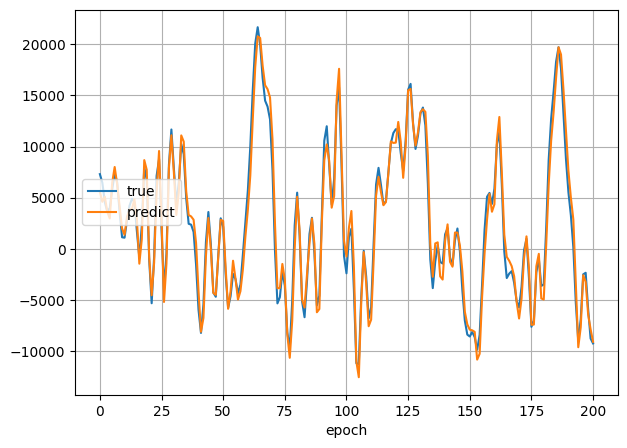

KeyboardInterrupt: ignored

In [52]:
series = df["x"]

size = int(series.shape[0] * 0.5)
train, test = series[:size], series[size:len(series)]
history = [x for x in train.values]
predictions = []

val = {"true":[], "predict":[]}
for t in test.values:
    model = ARIMA(history, order=(5,1,0)).fit()
    output = model.forecast()
    yhat = output[0]
    predictions.append(yhat)
    val["predict"].append(yhat)
    val["true"].append(t)
    history.append(t)
    live_plot(val)


In [53]:
X = data['x'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)


KeyboardInterrupt: ignored

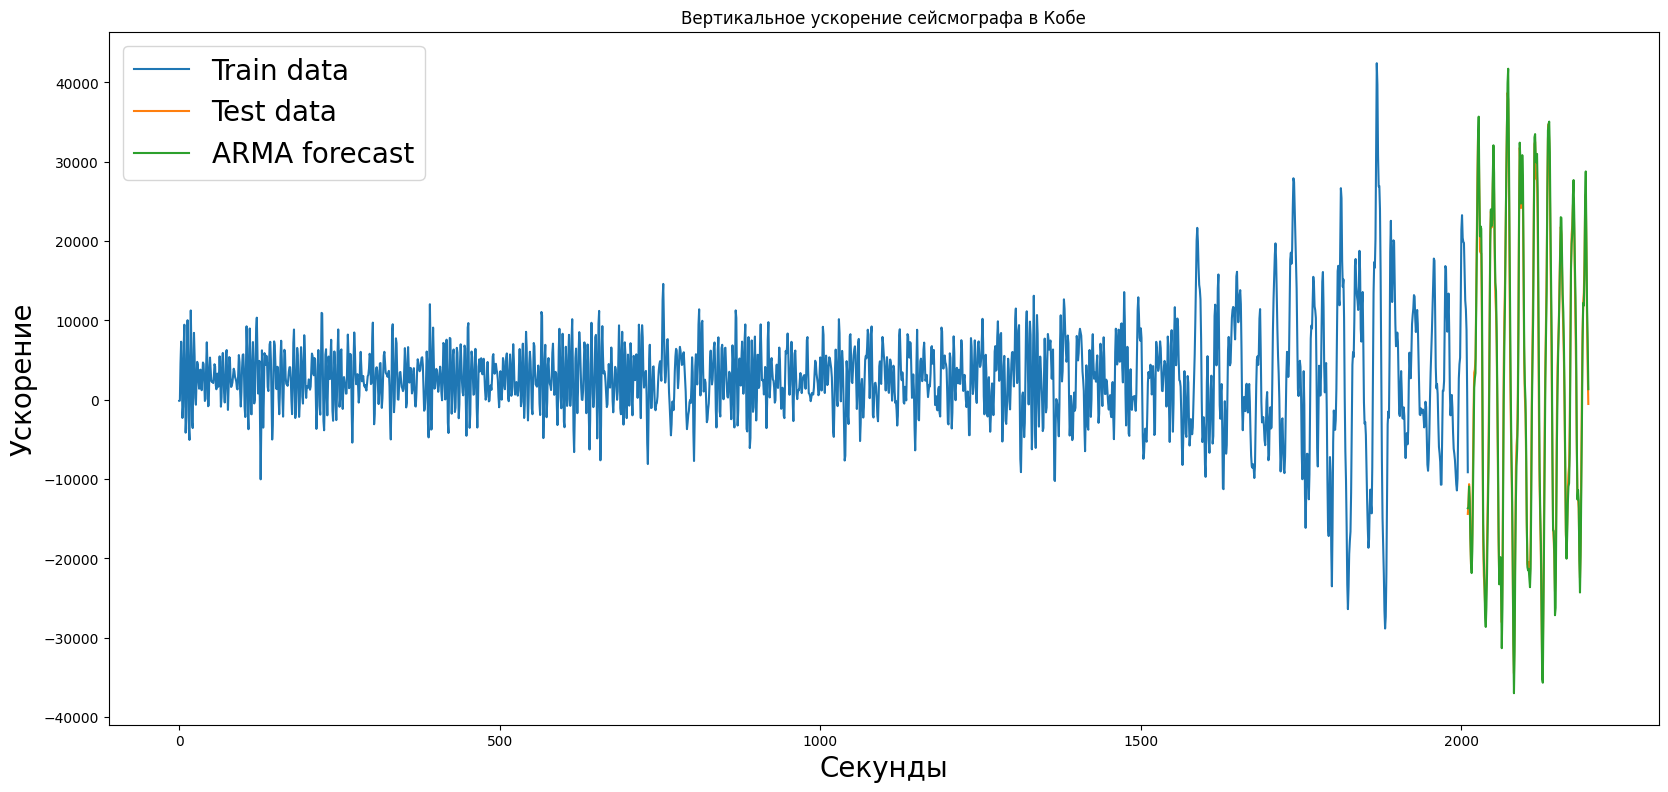

In [56]:
fig = plt.figure(figsize=(20, 9))
dur = len(arma_predictions)

plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_predictions, label='ARMA forecast')
plt.legend(fontsize="20")
plt.title('Вертикальное ускорение сейсмографа в Кобе')
plt.ylabel('Ускорение', fontsize="20")
plt.xlabel('Секунды', fontsize="20")
plt.show()



In [57]:
arima_model = ARIMA(data['x'], order=(10,2,10))
arima_model_fit = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                 3048
Model:               ARIMA(10, 2, 10)   Log Likelihood              -23163.842
Date:                Mon, 06 Nov 2023   AIC                          46369.683
Time:                        04:41:52   BIC                          46496.136
Sample:                             0   HQIC                         46415.133
                               - 3048                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7854      0.117     15.305      0.000       1.557       2.014
ar.L2         -2.8629      0.211    -13.545      0.000      -3.277      -2.449
ar.L3          3.7036      0.299     12.407      0.0

<Axes: >

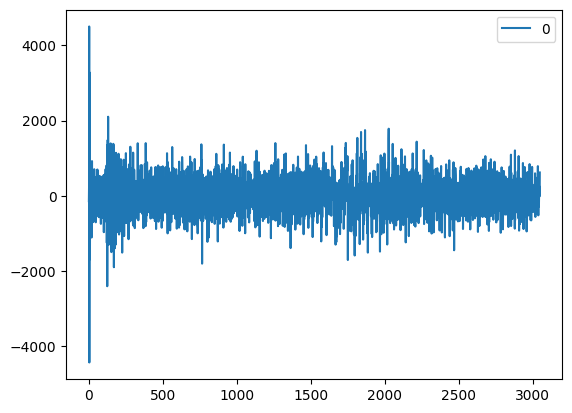

In [59]:
arima_residuals = pd.DataFrame(arima_model_fit.resid)
arima_residuals.plot()

In [60]:
# forecast предсказывает только следующее значение
output = arima_model_fit.forecast()

In [61]:
data['x'].fillna(data['x'].mean(), inplace=True)
X = data['x'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arima_predictions = list()
# walk-forward validation
for t in range(len(test)):
    arima_model = ARIMA(history, order=(10,2,5))
    arima_model_fit = arima_model.fit()
    output = arima_model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

KeyboardInterrupt: ignored

ValueError: ignored

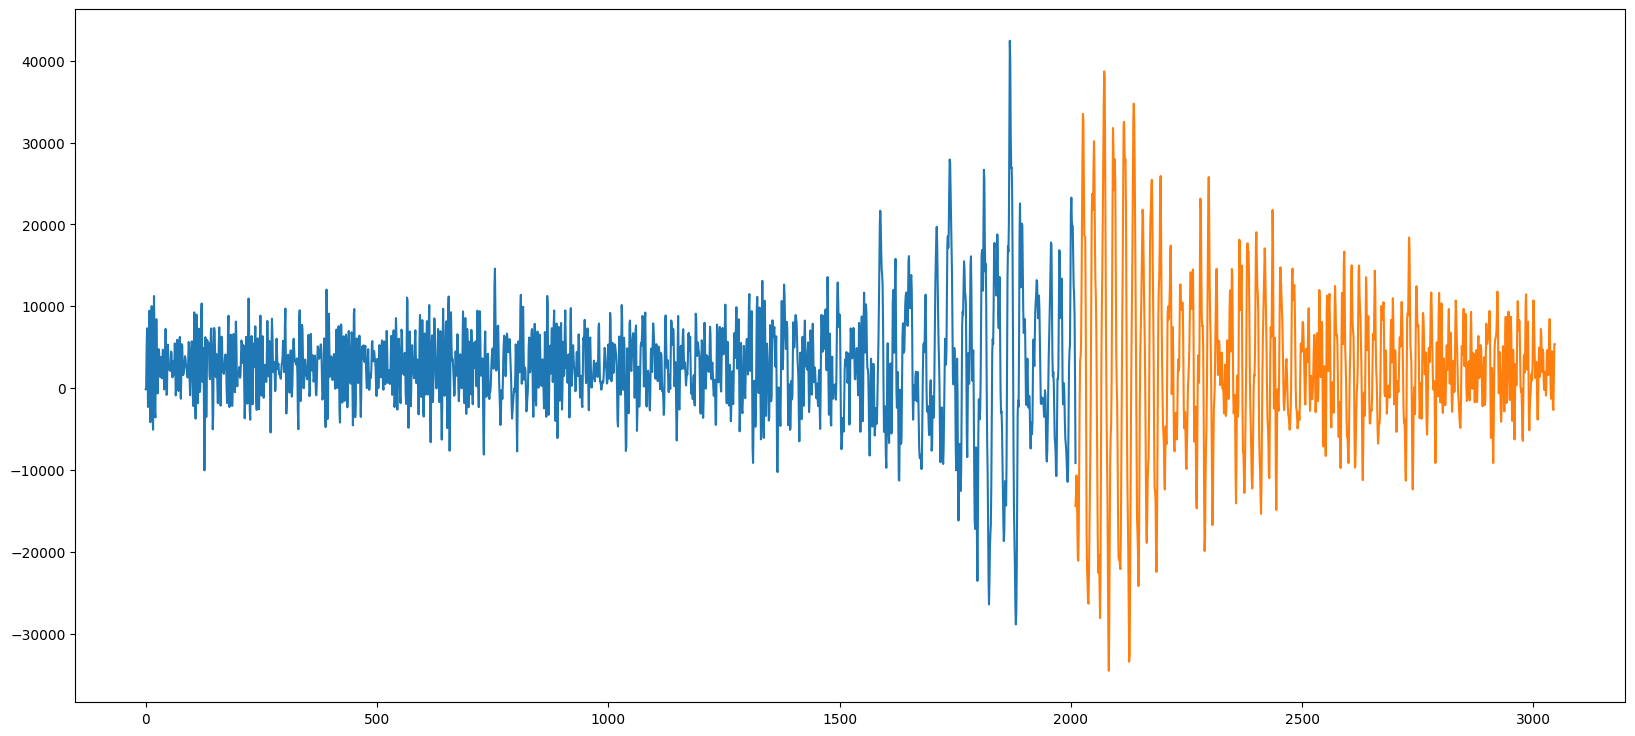

In [65]:
fig = plt.figure(figsize=(20, 9))
plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, len(X) - 1)], test, label='Test data')
plt.plot([i for i in range(size - 1, len(X) - 1)], arima_predictions, label='ARIMA forecast')
plt.legend(fontsize="20")
plt.title('Вертикальное ускорение сейсмографа в Кобе')
plt.ylabel('Ускорение', fontsize="20")
plt.xlabel('Секунды', fontsize="20")
plt.show()

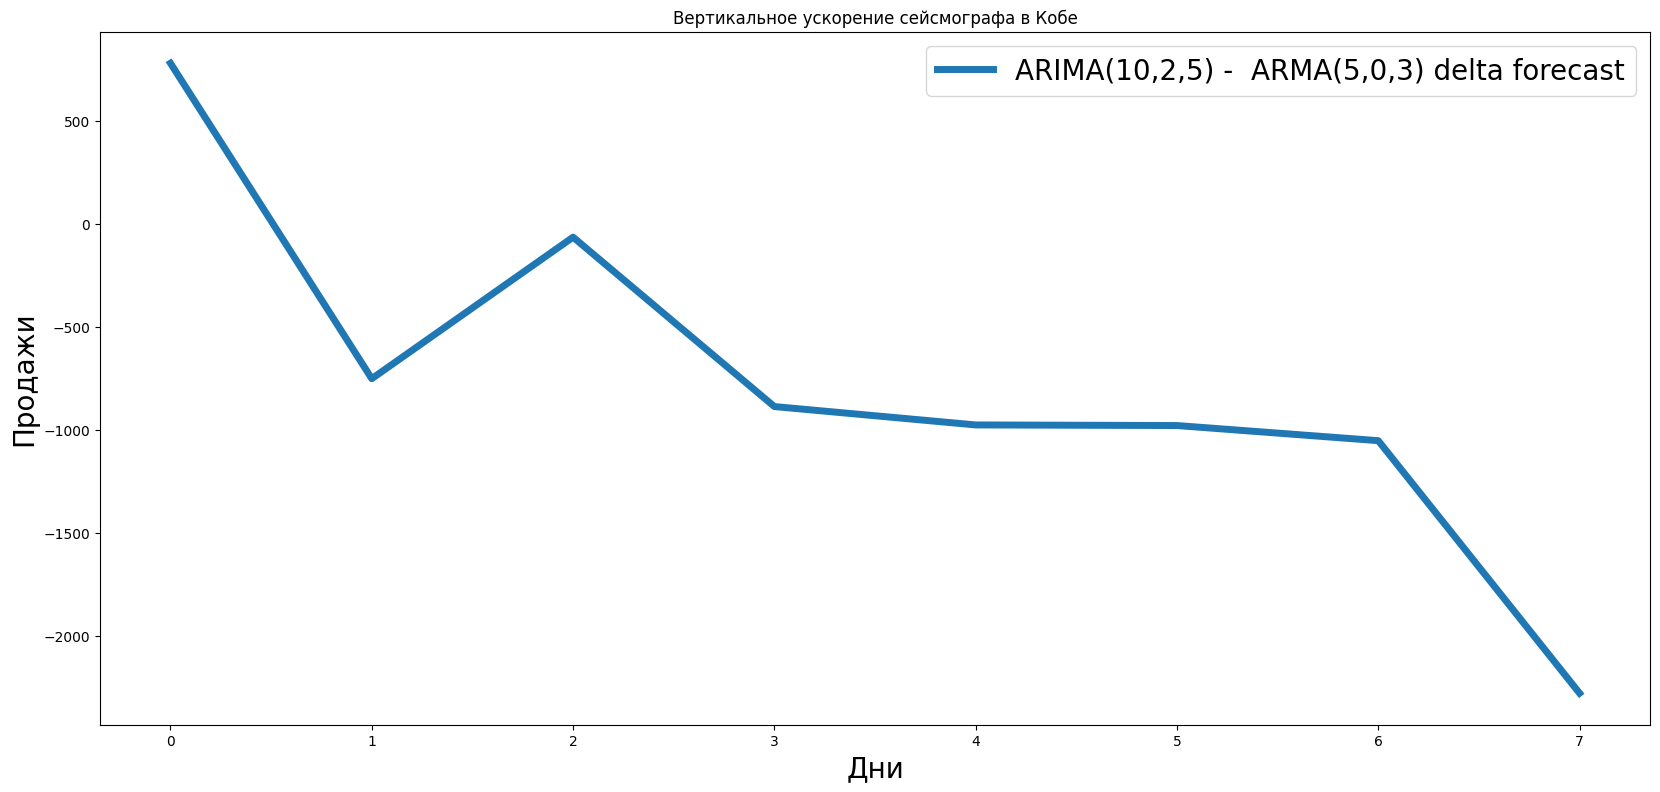

In [66]:
fig = plt.figure(figsize=(20, 9))

delta = []

for i in range(len(arima_predictions)):
    delta.append(arma_predictions[i] - arima_predictions[i])

plt.plot(delta, label='ARIMA(10,2,5) -  ARMA(5,0,3) delta forecast', linewidth=5)
plt.legend(fontsize="20")
plt.title('Вертикальное ускорение сейсмографа в Кобе')
plt.ylabel('Продажи', fontsize="20")
plt.xlabel('Дни', fontsize="20")
plt.show()

<Axes: >

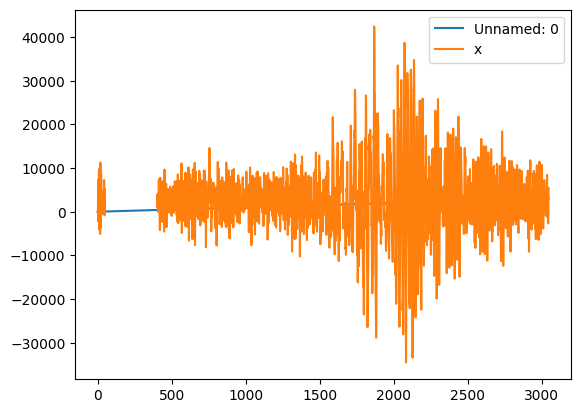

In [67]:
o_df = data.copy()

o_df["x"][50:400] = np.nan

o_df.plot()

<ipython-input-68-6fab53158d6e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["x"][50:400] = new_value


<Axes: title={'center': 'среднее из предыдущего и последующего'}>

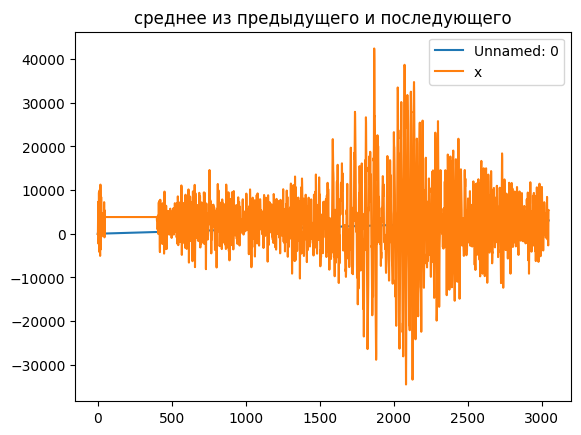

In [68]:
new_value = (o_df["x"][401] + o_df["x"][49])/2

o_df["x"][50:400] = new_value

o_df.plot(title="среднее из предыдущего и последующего")

<ipython-input-69-b8f3f0166956>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["x"][50:400] = new_value


<Axes: title={'center': 'Последующее значение'}>

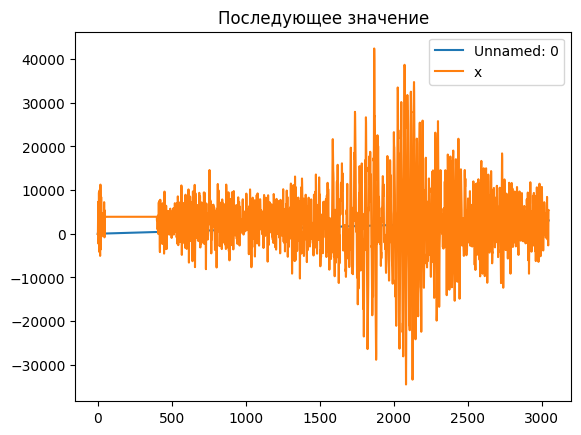

In [69]:
new_value = o_df["x"][401]

o_df["x"][50:400] = new_value

o_df.plot(title='Последующее значение')

<ipython-input-70-5d207bc64ed9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["x"][50:400] = new_value


<Axes: title={'center': 'Предыдущее значение'}>

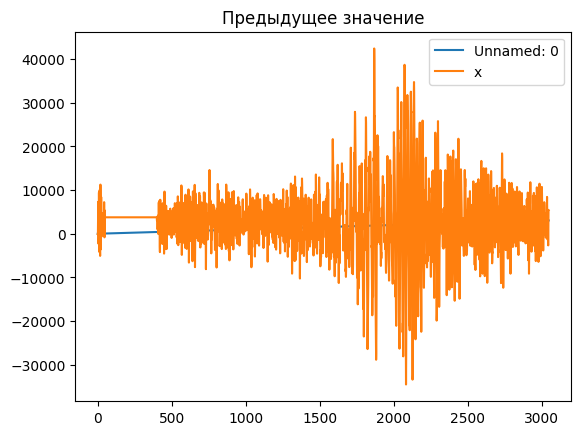

In [70]:
new_value = o_df["x"][49]

o_df["x"][50:400] = new_value

o_df.plot(title='Предыдущее значение')

<ipython-input-71-ee8753b5f8c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["x"][50:400] = new_value


<Axes: title={'center': 'медиана'}>

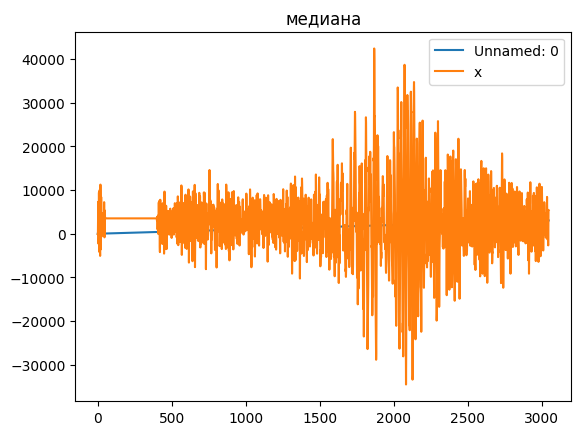

In [71]:
new_value = o_df["x"].median()

o_df["x"][50:400] = new_value

o_df.plot(title='медиана')

<ipython-input-72-d8000e44f5fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["x"][50:400] = new_value


<Axes: title={'center': 'среднее'}>

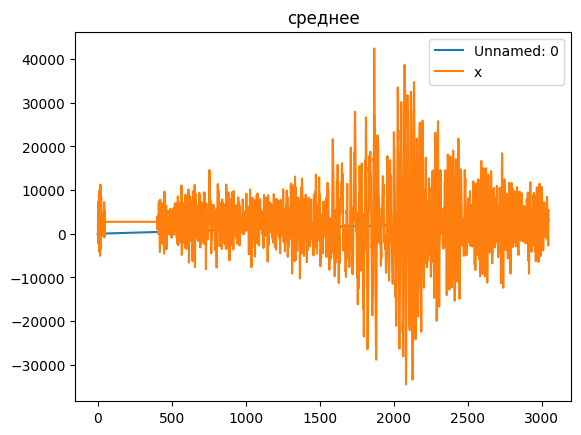

In [72]:

new_value = o_df["x"].mean()

o_df["x"][50:400] = new_value

o_df.plot(title='среднее')

<ipython-input-73-afd9332ad010>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["x"][50:400] = np.nan


<Axes: title={'center': 'zero'}>

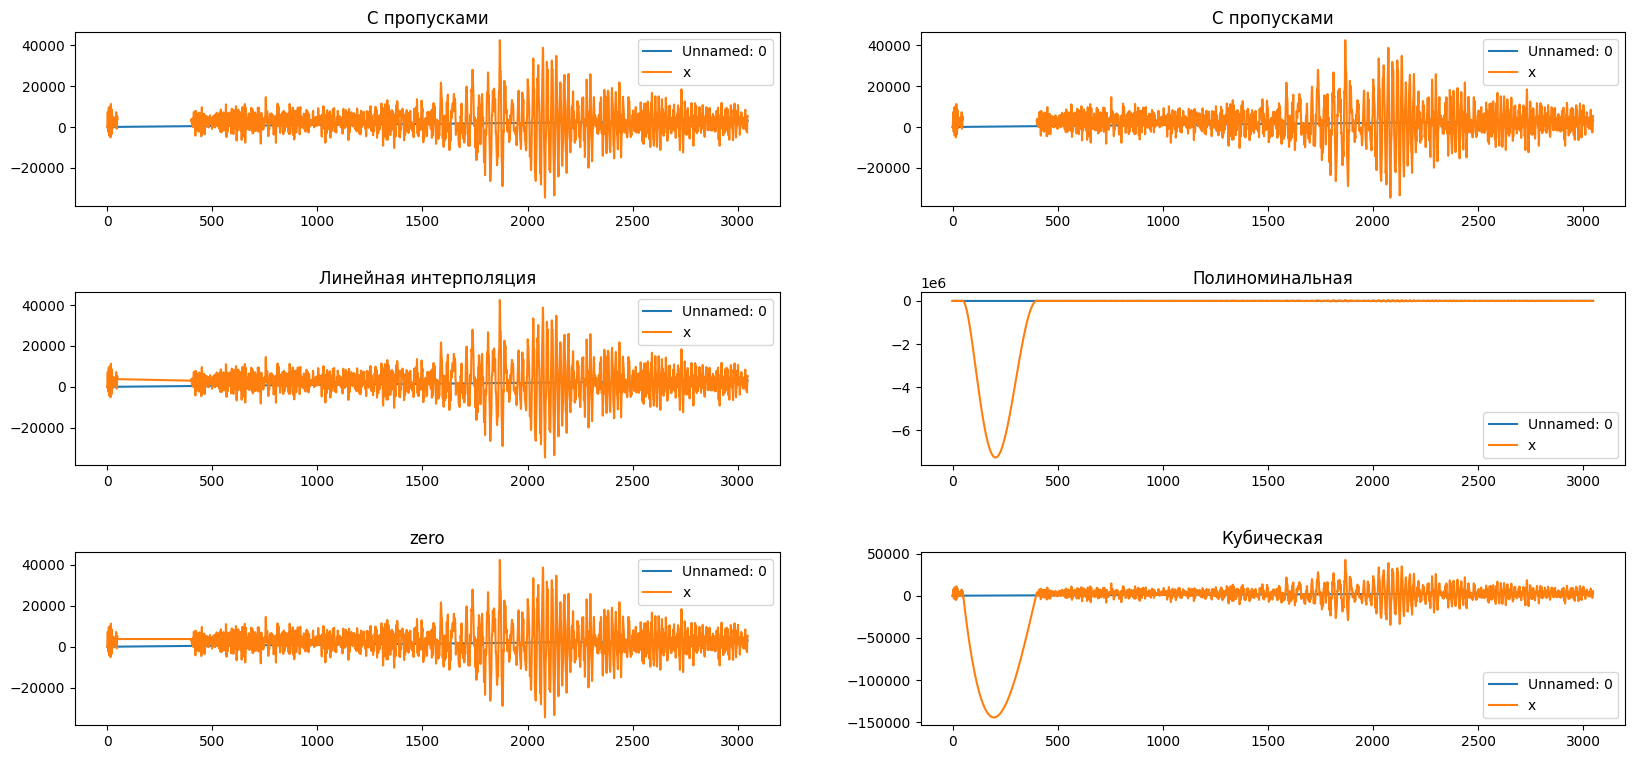

In [73]:
o_df["x"][50:400] = np.nan

lin_df = o_df.interpolate(method="linear")

cub_df = o_df.interpolate(method="cubic")

pol_df = o_df.interpolate(method="polynomial", order=5)

zero_df = o_df.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))

o_df.plot(title="С пропусками", ax = original_ax)
o_df.plot(title="С пропусками", ax = plt.subplot2grid(layout, (0, 1)))
lin_df.plot(title="Линейная интерполяция", ax = lin_ax)
cub_df.plot(title="Кубическая", ax = cub_ax)
pol_df.plot(title="Полиноминальная", ax = pol_ax)
zero_df.plot(title="zero", ax=zero_ax)

In [74]:
import seaborn as sns

<Axes: >

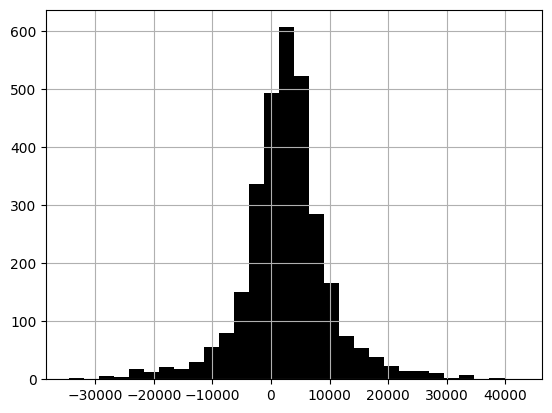

In [75]:
data["x"].hist(bins=30, color="black")

<Axes: >

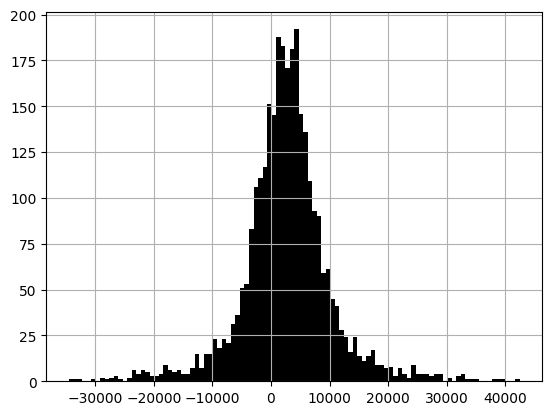

In [76]:
data["x"].hist(bins=100, color="black",)

Text(0.5, 1.0, 'x')

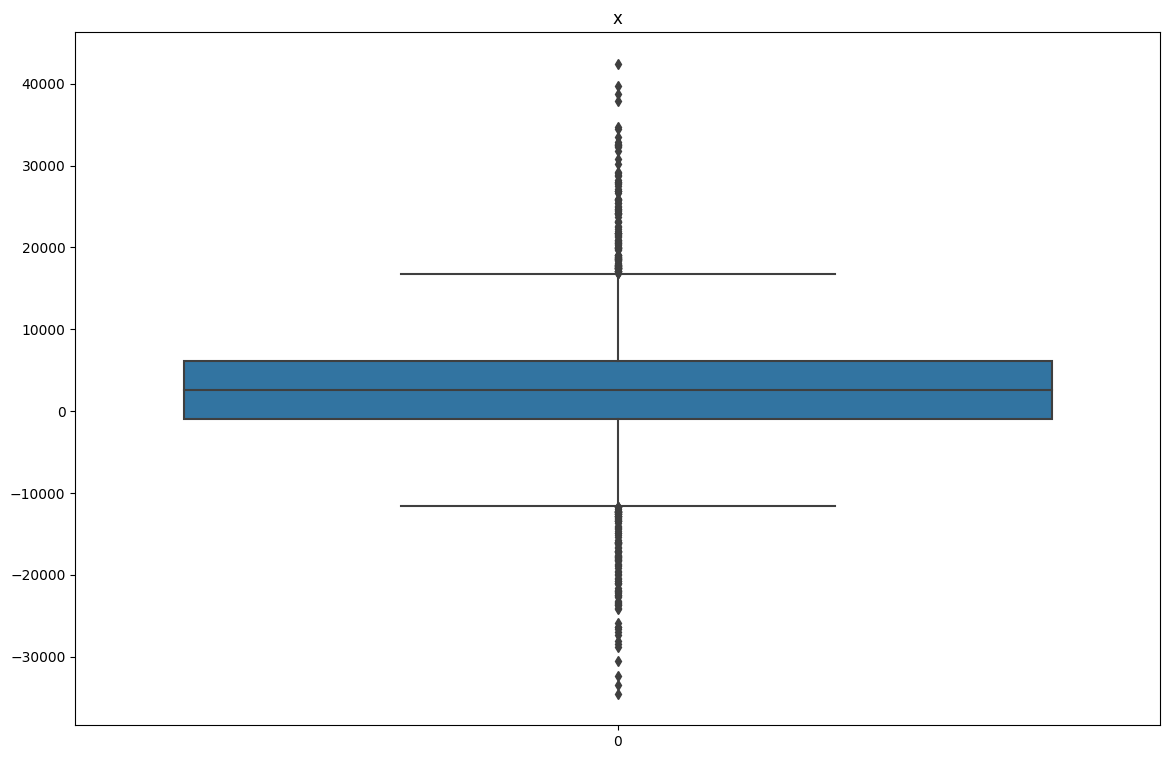

In [77]:
fig = plt.figure(figsize=(14, 9))

sns.boxplot(data.x).set_title('x')

Text(0.5, 1.0, 'Вертикальное ускорение')

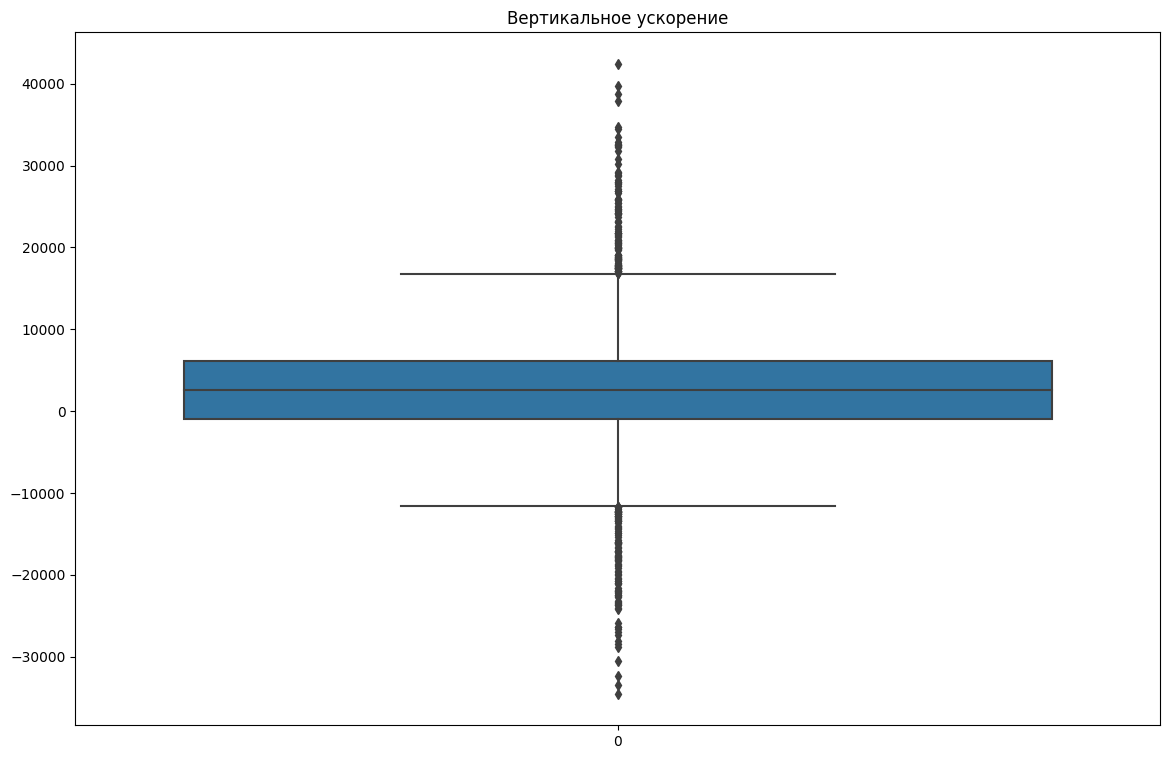

In [78]:
fig = plt.figure(figsize=(14, 9))
ax = sns.boxplot(data["x"])
ax.set_title('Вертикальное ускорение')

In [79]:
from sklearn import preprocessing, svm

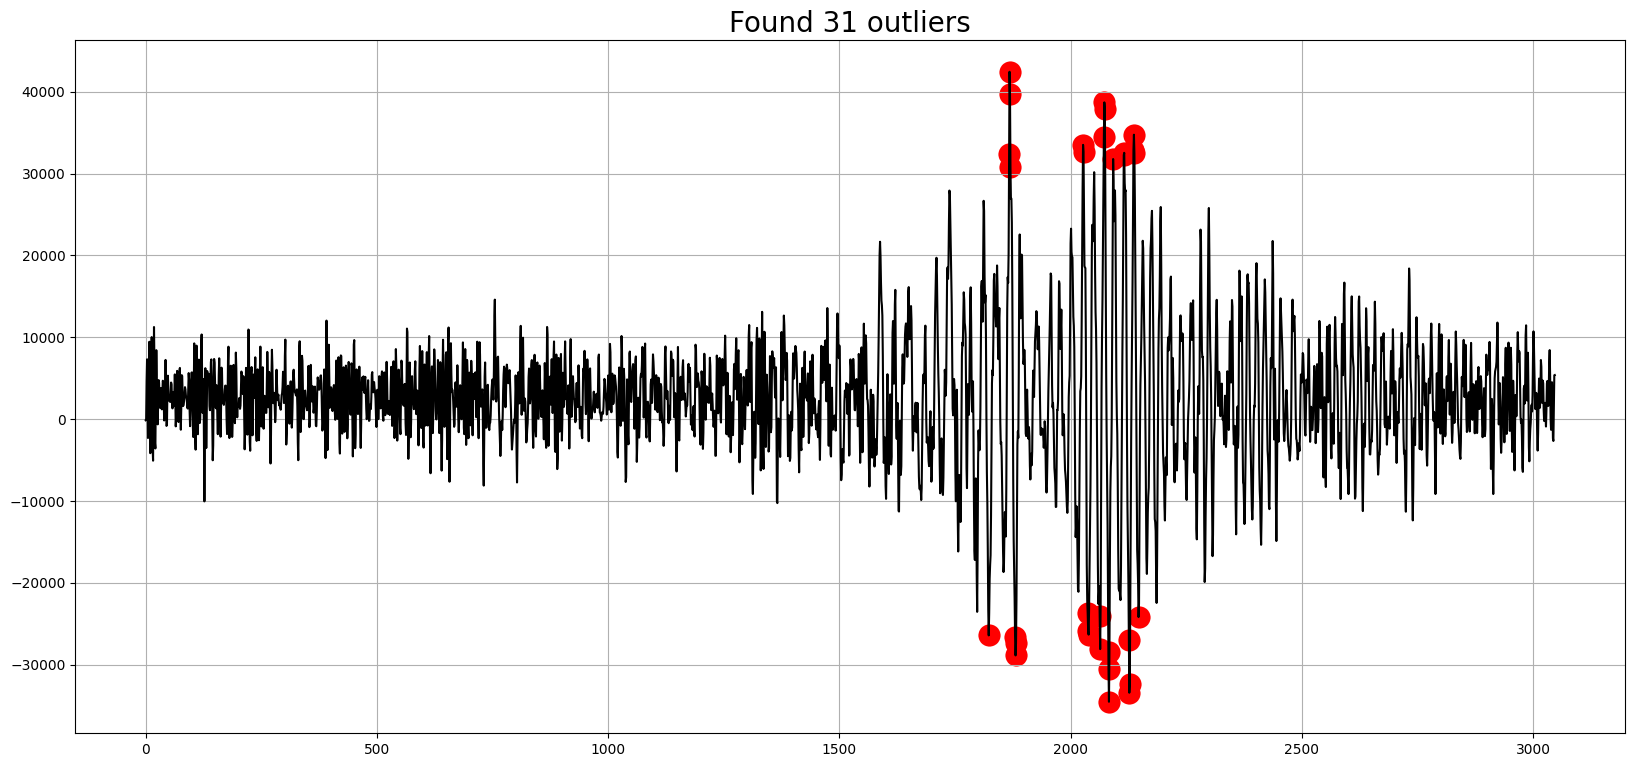

In [80]:
scaler = preprocessing.StandardScaler()
perc = 0.01

local_df = data["x"]

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)
## dtf output
dtf_outliers =local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                                            x: 1 if x==-1 else 0)
## plot
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
        color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()

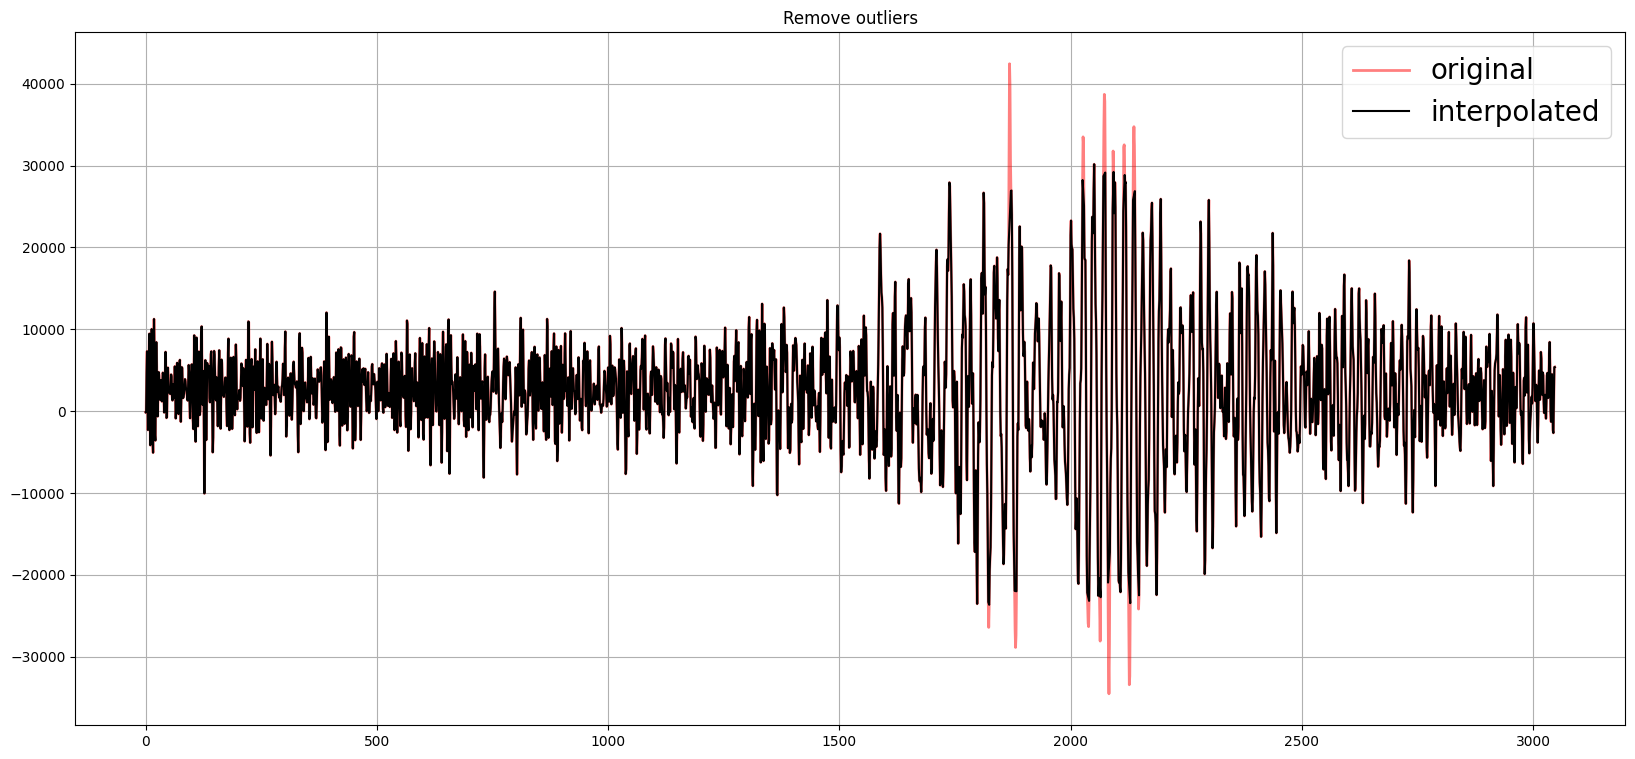

In [81]:
outliers_idx = dtf_outliers[dtf_outliers["outlier"]==1].index

ts_clean = local_df.copy()
ts_clean.loc[outliers_idx] = np.nan
ts_clean = ts_clean.interpolate(method="linear")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Remove outliers", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()